In [1]:
import os
import numpy as np
import argparse


import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
from spiral.main import SPIRAL_integration
from spiral.layers import *
from spiral.utils import *
from spiral.CoordAlignment import CoordAlignment
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

SPIRAL integration

In [2]:
############train#############
torch.cuda.cudnn_enabled = False
seed=1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

read in orignal data (feat:ncell*ngene; edge:nedge*2; meta:ncell*2)

In [26]:
dirs="/data02/tguo/space_batch_effect/Hippo/"
samples=["10X_Normal","10X_DAPI","10X_FFPE"]
SEP=','
net_cate='_KNN_'
knn=6

N_WALKS=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=6


feat_file=[]
edge_file=[]
meta_file=[]
coord_file=[]
flags=''
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input/"+str(samples[i])+"_mat.csv")
    edge_file.append(dirs+"gtt_input/"+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    meta_file.append(dirs+"gtt_input/"+str(samples[i])+"_meta.csv")
    coord_file.append(dirs+"gtt_input/"+str(samples[i])+"_coord.csv")
    flags=flags+'_'+samples[i]
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
M=3

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--zdim', type=int, default=32, help='Dim of embedding.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default=MeanAggregator, help='Function of aggregator.')
parser.add_argument('--num_samples', type=str, default=20, help='number of neighbors to sample.')

parser.add_argument('--N_WALKS', type=str, default=6, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=str, default=1, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=str, default=6, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=str, default=6, help='number of negative pairs.')


parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=128, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.')
parser.add_argument('--Q', type=float, default=10, help='Weight negative loss for sage losss .')

params,unknown=parser.parse_known_args()

In [5]:
SPII=SPIRAL_integration(params,feat_file,edge_file,meta_file)

In [6]:
SPII.train()

--------------------------------
Training.
processed: 100: 100%|██████████| 100/100 [3:10:03<00:00, 114.03s/it, CLAS_loss=0.586, DISC_loss=0.938, GS_loss=0.927, total_loss=696]


In [7]:
SPII.model.eval()
all_idx=np.arange(SPII.feat.shape[0])
all_layer,all_mapping=layer_map(all_idx.tolist(),SPII.adj,len(SPII.params.GSdims))
all_rows=SPII.adj.tolil().rows[all_layer[0]]
all_feature=torch.Tensor(SPII.feat.iloc[all_layer[0],:].values).float().cuda()
all_embed,ae_out,clas_out,disc_out=SPII.model(all_feature,all_layer,all_mapping,all_rows,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed,gs_embed,embed]=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
names=['GTT_'+str(i) for i in range(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.feat.index,columns=names)
embed1.to_csv(dirs+"gtt_output/SPIRAL"+flags+"embed_1.csv")

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


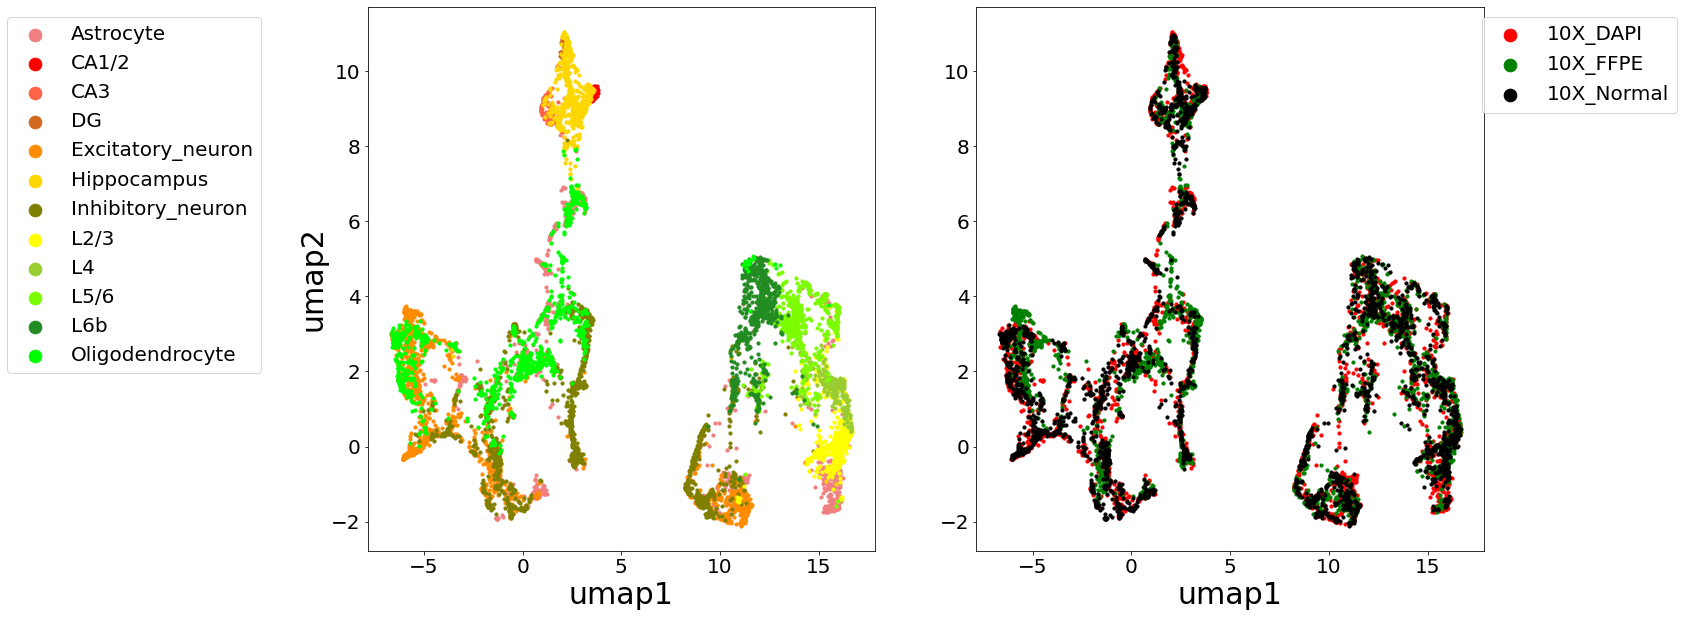

In [8]:
celltype=SPII.meta[:,0]
batch=SPII.meta[:,1]
ul=np.unique(celltype)
ub=np.unique(batch)
import umap.umap_ as umap
import matplotlib.pyplot as plt
umap_mat=umap.UMAP().fit_transform(embed[:,SPII.params.znoise_dim:])
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=10
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

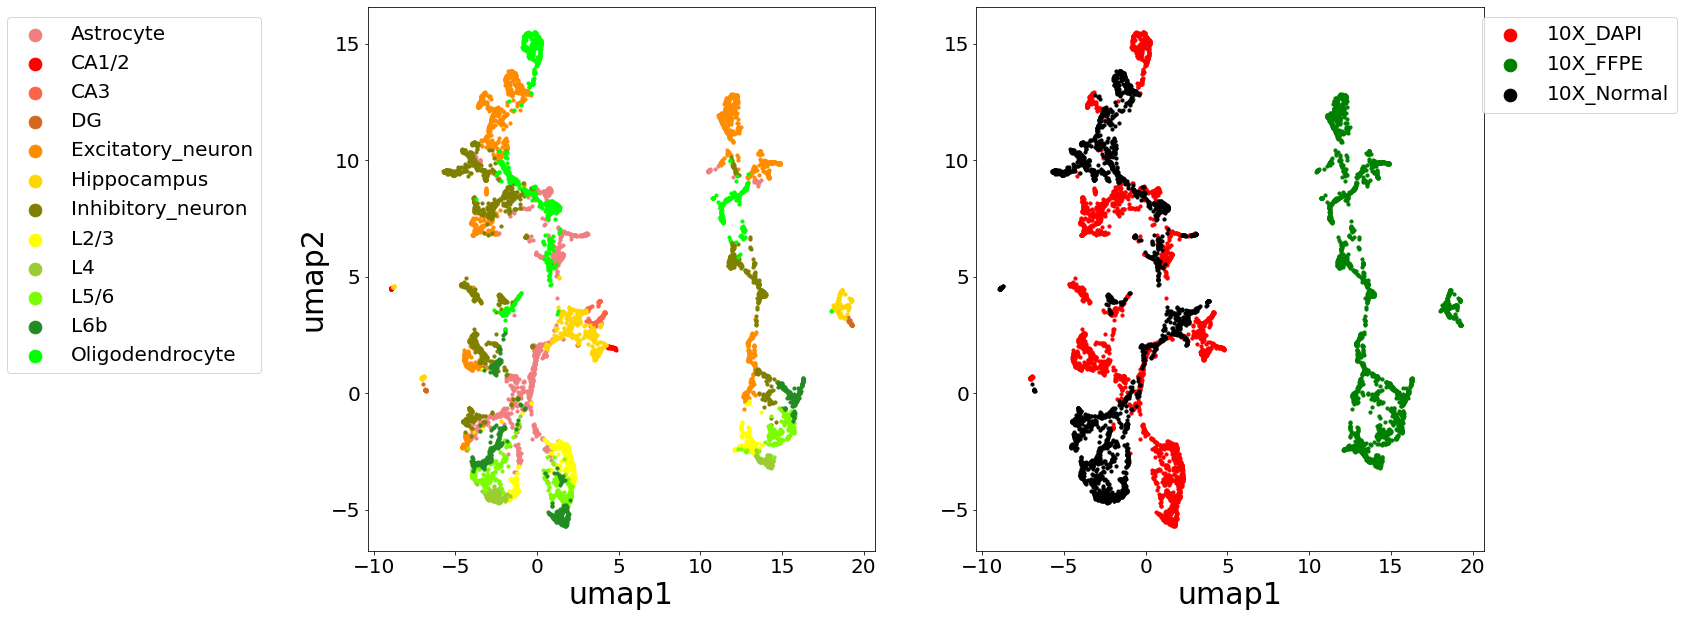

In [12]:
celltype=SPII.meta[:,0]
batch=SPII.meta[:,1]
ul=np.unique(celltype)
ub=np.unique(batch)
import umap.umap_ as umap
import matplotlib.pyplot as plt
data_pca=PCA(n_components=30).fit_transform(SPII.feat.values)
umap_mat=umap.UMAP().fit_transform(data_pca)
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=10
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

clustering

In [21]:
import anndata
import scanpy as sc
ann=anndata.AnnData(SPII.feat)
ann.obsm['GTT']=embed1.iloc[:,4:]
sc.pp.neighbors(ann,use_rep='GTT')
sc.tl.leiden(ann,resolution=1.5)
sc.tl.louvain(ann,resolution=1.5)
ann.obs['celltype']=SPII.meta[:,0]
ann.obs['batch']=SPII.meta[:,1]
ub=np.unique(ann.obs['batch'])
sc.tl.umap(ann)


coord=pd.read_csv(dirs+"gtt_input/"+str(samples[0])+"_coord.csv",header=0,index_col=0)
for i in np.arange(1,len(samples)):
    coord=pd.concat((coord,pd.read_csv(dirs+"gtt_input/"+str(samples[i])+"_coord.csv",header=0,index_col=0)))
coord.columns=['y','x']
ann.obsm['spatial']=coord.loc[ann.obs_names,:]
pd.DataFrame(ann.obs['louvain']).to_csv(dirs+"gtt_output/SPIRAL"+flags+"_louvain_1.csv")

... storing 'celltype' as categorical
... storing 'batch' as categorical


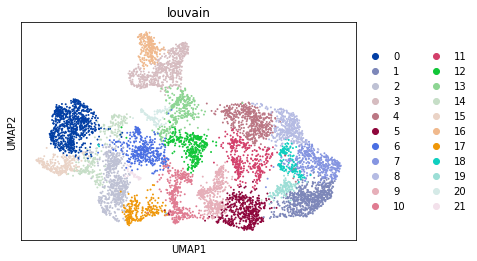

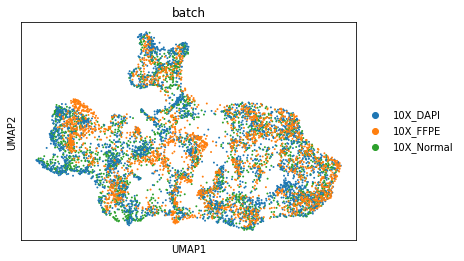

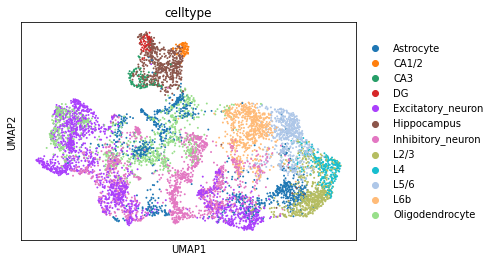

In [22]:
sc.pl.umap(ann,color='louvain')
sc.pl.umap(ann,color='batch')
sc.pl.umap(ann,color='celltype')

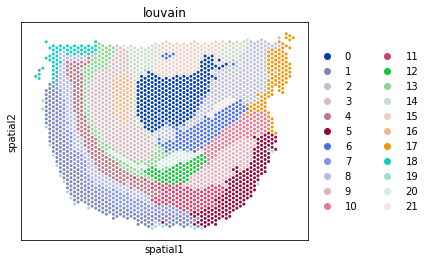

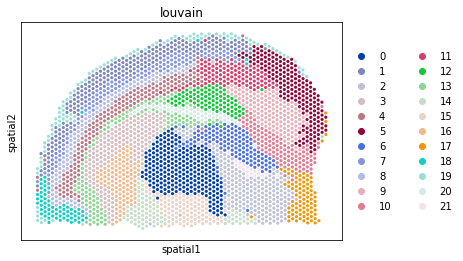

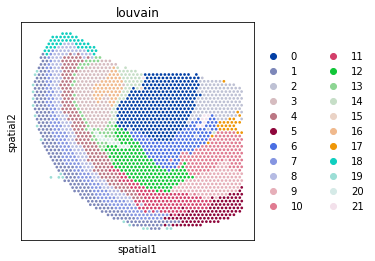

In [55]:
ann1=ann[ann.obs['batch']==ub[0],:]
sc.pl.spatial(ann1,color="louvain", spot_size=100)
ann1=ann[ann.obs['batch']==ub[1],:]
sc.pl.spatial(ann1,color="louvain", spot_size=200)
ann1=ann[ann.obs['batch']==ub[2],:]
sc.pl.spatial(ann1,color="louvain", spot_size=200)

SPIRAL alignment

In [47]:
embed_file=dirs+"gtt_output/SPIRAL"+flags+"embed_1.csv"
cluster_file=dirs+"gtt_output/SPIRAL"+flags+"_louvain_1.csv"
input_file=[meta_file,coord_file,embed_file,cluster_file]
output_dirs=dirs+"gtt_output/SPIRAL_alignment/"
ub=['10X_Normal','10X_DAPI','10X_FFPE']

In [48]:
alpha=0.5
types="weighted_mean"
clust_cate='louvain'
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
CA=CoordAlignment(input_file=input_file,output_dirs=output_dirs,ub=ub,flags=flags,clust_cate=clust_cate,R_dirs=R_dirs,alpha=alpha,types=types)
New_Coord=CA.New_Coord
New_Coord.to_csv(output_dirs+"new_coord"+flags+".csv")

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

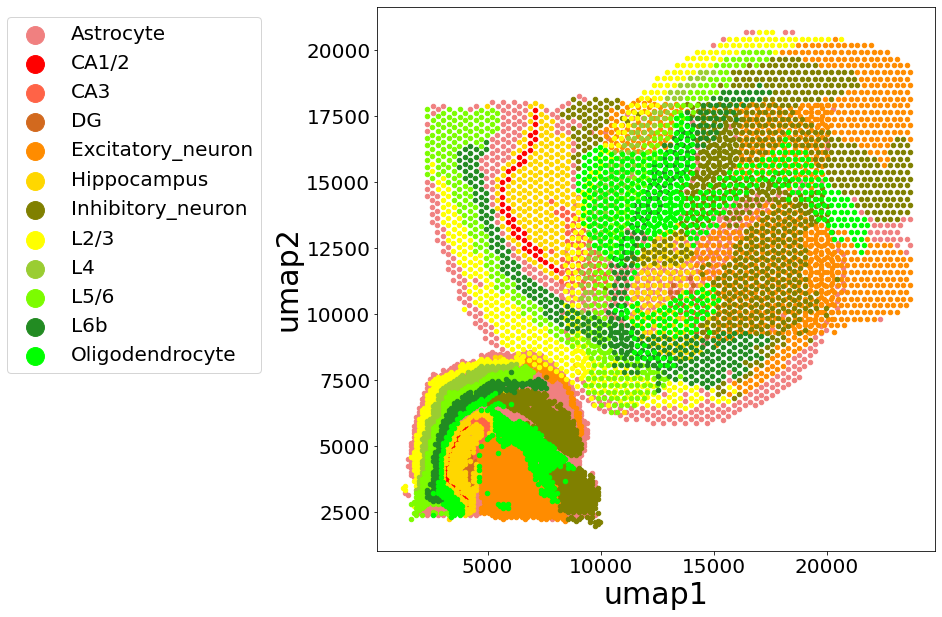

In [50]:
New_Coord1=CA.Coord.values
celltype=New_Coord1[:,3]
ul=np.unique(celltype)
import matplotlib.pyplot as plt
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(10,10))
size=20
for i in range(len(ul)):
    axs.scatter(New_Coord1[np.where(celltype==ul[i])[0],0],New_Coord1[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs.set_xlabel("umap1",fontsize=30)
axs.set_ylabel("umap2",fontsize=30)
axs.legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)

In [53]:
New_Coord

,x,y,clusters,celltype,batch
Normal-AAACAAGTATCTCCCA-1,7238.000000,8228.000000,5,Excitatory_neuron,10X_Normal
Normal-AAACAATCTACTAGCA-1,1611.000000,4170.000000,1,Astrocyte,10X_Normal
Normal-AAACACCAATAACTGC-1,8315.000000,2518.000000,14,Excitatory_neuron,10X_Normal
Normal-AAACAGAGCGACTCCT-1,2928.000000,7678.000000,1,Astrocyte,10X_Normal
Normal-AAACCGGGTAGGTACC-1,6280.000000,3137.000000,15,Excitatory_neuron,10X_Normal
...,...,...,...,...,...
FFPE-CCACGGTGCCCGGTAG-1,7477.000000,4434.714286,21,Excitatory_neuron,10X_FFPE
FFPE-GCGAGAGTTGCGTCCA-1,7802.000000,4267.571429,21,Excitatory_neuron,10X_FFPE
FFPE-GTTCATCGTTTGGCTG-1,7904.571429,4208.428571,21,Excitatory_neuron,10X_FFPE
FFPE-TCAAGAAATACTAGCT-1,7699.857143,4326.714286,21,Excitatory_neuron,10X_FFPE
